# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [1]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [2]:
from nltk import wordpunct_tokenize
from nltk import FreqDist

## RT

Загрузим датасет rt. Одновременно сделаем преобразование даты из строки

In [211]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [212]:
data_rt = pd.read_csv('../data/rt.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"')

In [213]:
# Проверим преобразование
data_rt.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors               float64
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [214]:
data_rt.shape

(106644, 16)

In [215]:
# Так выглядет датасет RT
data_rt.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-06-26 14:00:00,https://russian.rt.com/russia/news/644595-avto...,-,Россия,NaN,Эксперт прокомментировал ситуацию с возможным ...,"Как считает эксперт, россиянам не стоит пережи...",-,-,-,-,-,-,-,-,-
1,2019-06-26 19:56:00,https://russian.rt.com/sport/article/644740-nu...,-,Спорт,NaN,"Встреча Нурмагомедова с Макгрегором, восстанов...",«Конор может посетить поединок Хабиба с Порье»...,-,-,-,-,-,-,-,-,-
2,2019-06-26 14:52:00,https://russian.rt.com/russia/news/644619-puti...,-,Россия,NaN,Путин подарил Зюганову на юбилей материалы съе...,"Открывая заседание Госсовета в Кремле, Путин п...",-,-,-,-,-,-,-,-,-
3,2019-06-26 14:44:00,https://russian.rt.com/world/news/644618-parla...,-,Мир,NaN,"Парламентарии США, ФРГ и России проведут встре...",Об этом информируетnРИА Новостиnсо ссылкой на ...,-,-,-,-,-,-,-,-,-
4,2019-06-26 14:42:00,https://russian.rt.com/sport/news/644617-mok-a...,-,Спорт,NaN,МОК принял решение лишить признания AIBA,Решением 134-й сессии МОК в швейцарской Лозанн...,-,-,-,-,-,-,-,-,-


In [216]:
# Выясним в каким столбцах есть пустые данные
data_rt.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text            True
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [217]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_rt['text'].isnull().sum())
data_rt[data_rt['text'].isnull()]

Кол-во строк с значением NaN в столбце "Text" =  12


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
37474,2019-06-05 13:47:00,https://russian.rt.com/russia/video/638188-obr...,-,Россия,NaN,\n В Дагестане люди пытаются вручну...,NaN,-,-,-,-,-,-,-,-,-
38249,2017-12-11 19:32:00,https://russian.rt.com/sport/article/459073-ro...,-,Спорт,NaN,Не без труда: Россия в овертайме победила Южну...,NaN,-,-,-,-,-,-,-,-,-
43956,2017-12-08 01:29:00,https://russian.rt.com/world/article/457555-la...,-,Мир,NaN,"Будущее Сирии, перенос столицы Израиля и ситуа...",NaN,-,-,-,-,-,-,-,-,-
84132,2016-07-29 10:08:01,https://russian.rt.com/article/314450-dollar-p...,-,Россия,NaN,Доллар превысил 67 рублей,NaN,-,-,-,-,-,-,-,-,-
86097,2016-07-27 11:24:00,https://russian.rt.com/article/314142-sbornaya...,-,Спорт,NaN,Сборная России по тхэквондо в полном составе д...,NaN,-,-,-,-,-,-,-,-,-
86103,2016-07-27 08:56:37,https://russian.rt.com/article/314121-cb-rf-ot...,-,Россия,NaN,ЦБ РФ отозвал лицензию у банка «БФГ-Кредит»,NaN,-,-,-,-,-,-,-,-,-
92836,2016-07-19 17:43:00,https://russian.rt.com/article/312972-mok-inic...,-,Спорт,NaN,МОК инициирует повторный анализ проб российски...,NaN,-,-,-,-,-,-,-,-,-
93872,2017-11-09 18:22:00,https://russian.rt.com/world/article/447764-ss...,-,Мир,NaN,«Это могла быть только внутренняя утечка»: экс...,NaN,-,-,-,-,-,-,-,-,-
93917,2016-07-18 16:47:26,https://russian.rt.com/article/312776-otchyot-...,-,Спорт,NaN,"Отчёт WADA: Метод, используемый ФСБ для вскрыт...",NaN,-,-,-,-,-,-,-,-,-
93919,2016-07-18 16:25:00,https://russian.rt.com/article/312771-otchyot-...,-,Спорт,NaN,Отчёт WADA: Минспорт РФ и ФСБ участвовали в за...,NaN,-,-,-,-,-,-,-,-,-


In [218]:
#Удалим эти строки
data_rt.drop(data_rt[data_rt.text.isnull()].index, inplace=True)

In [219]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_rt['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


Посмотрим сколько элементов Nan в столбце авторов

In [220]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_rt['authors'].isnull().sum())

Кол-во строк с значением NaN в столбце "authors" =  106632


Как видим все значения авторов Nan. Можно не использовать данные столбец

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [221]:
def analysis_columns(columns):
    for column in columns:
        if column not in ['url', 'date', 'topics', 'authors', 'title', 'text']:
            yield(print(str(column) + ':', data_rt[column].unique()))

In [222]:
data_columns = list(analysis_columns(data_rt.columns))

edition: ['-']
reposts_fb: ['-']
reposts_vk: ['-']
reposts_ok: ['-']
reposts_twi: ['-']
reposts_lj: ['-']
reposts_tg: ['-']
likes: ['-']
views: ['-']
comm_count: ['-']


Значений нет, можно удалять

In [223]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_rt.text.duplicated().sum())

Кол-во одинаковых текстов: 282


In [224]:
data_rt = data_rt.drop_duplicates(subset='text')

In [225]:
data_rt.shape

(106350, 16)

### Анализ дат

In [226]:
print('Минимальная дата в датасете:', data_rt.date.min())
print('Максимальная дата в датасете:', data_rt.date.max())

Минимальная дата в датасете: 2014-06-16 18:36:02
Максимальная дата в датасете: 2019-08-02 14:10:00


#### Распределение количества новостей по месяцам

In [227]:
# Вынесем месяц и год новости в отдельные столбцы
data_rt['month'] = data_rt.date.apply(lambda x: x.month)
data_rt['year'] = data_rt.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_rt.groupby(['year', 'month']).text.nunique().reset_index()

In [228]:
df.head()

,year,month,text
0,2014,6,1
1,2014,9,396
2,2014,10,1036
3,2014,11,1389
4,2014,12,1657


In [229]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [230]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [231]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [232]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
29,05-2019,8268
20,12-2017,8266
26,11-2018,8130
22,05-2018,8088
19,11-2017,7793


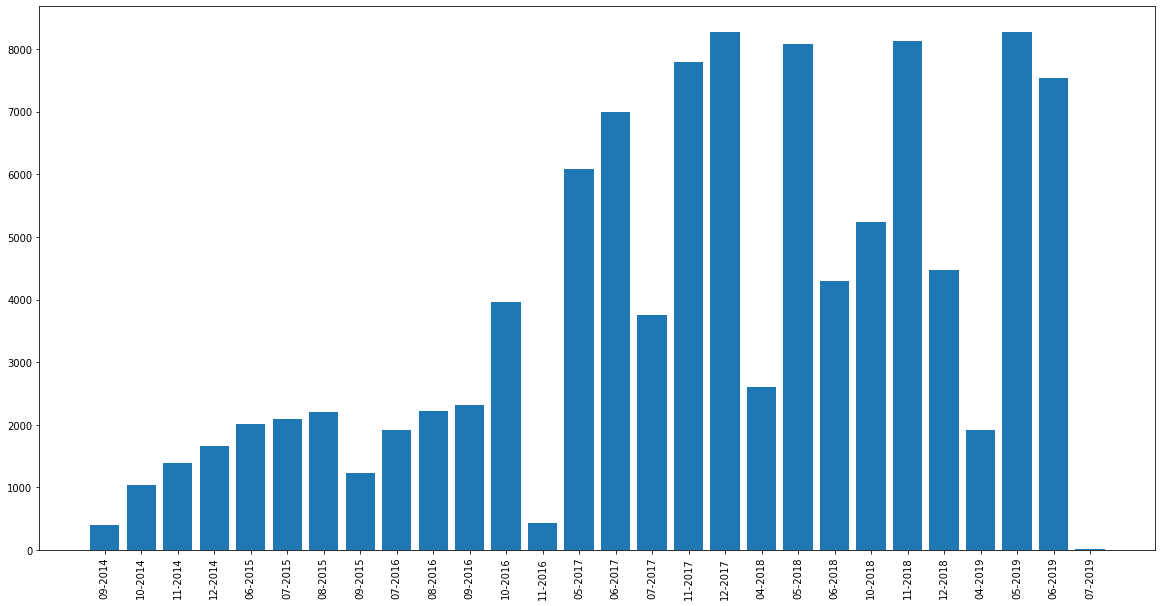

In [233]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
plt.show()

In [72]:
# Удалим часть символов

In [234]:
import re

In [235]:
def prepare_text(news_text):
    for news in news_text:
        news = re.sub("[«»—!\"#$%&()*+,-./:;<=>?@[\]^_{|}~]", " ", news) # Знаки препинания
        news = re.sub("\'", "", news) # Апострофы
        news = re.sub("\s+", " ", news) # Символ новой строки
        yield(news)  

In [236]:
data_rt.text = list(prepare_text(data_rt.text.values.tolist()))

In [239]:
def text_to_token(text):
    text = text.lower()
    return wordpunct_tokenize(text)

In [240]:
def data_withoun_stopwords(text):
    text = [token for token in text if token not in stopwords]
    return text

In [241]:
dictionary_with_stopwords = FreqDist()

In [245]:
dictionary_without_stopwords = FreqDist()

In [243]:
for token in data_rt.text.values:
    dictionary_with_stopwords.update(text_to_token(token))

In [246]:
stopwords_01 = open('../nlp/preprocessing/stopwords.txt', 'r', encoding='UTF-8')
stopwords_01 = stopwords_01.read().split('\n')
stopwords_02 = open('../nlp/preprocessing/stopwords_02.txt', 'r', encoding='UTF-8')
stopwords_02 = stopwords_02.read().split('\n')

In [247]:
stopwords = stopwords_01 + stopwords_02

In [248]:
for token in data_rt.text.values:
    dictionary_without_stopwords.update(data_withoun_stopwords(text_to_token(token)))

In [244]:
# Посмотрим 20 самых популярных слов без удаления стопслов и построим по ним график
dictionary_with_stopwords.most_common(20)

[('в', 600376),
 ('и', 328650),
 ('на', 264385),
 ('что', 226495),
 ('с', 168707),
 ('не', 148020),
 ('по', 130894),
 ('n', 108119),
 ('из', 64797),
 ('за', 63819),
 ('о', 58741),
 ('это', 58449),
 ('для', 57910),
 ('к', 55047),
 ('россии', 53492),
 ('как', 52479),
 ('а', 51124),
 ('он', 50399),
 ('его', 45368),
 ('nранее', 44088)]

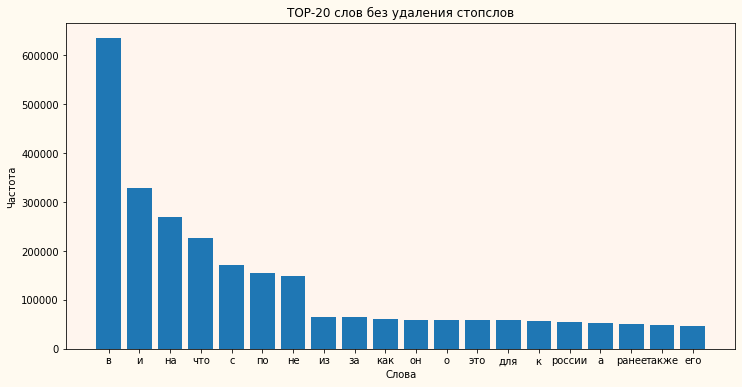

In [191]:
x = dict(dictionary_with_stopwords.most_common(20)).keys()
y = dict(dictionary_with_stopwords.most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

In [249]:
# Посмотрим 20 самых популярных слов после удаления стопслов и построим по ним график
dictionary_without_stopwords.most_common(20)

[('n', 108119),
 ('россии', 53492),
 ('nранее', 44088),
 ('сша', 36482),
 ('nв', 33950),
 ('заявил', 23726),
 ('nпо', 23501),
 ('словам', 21936),
 ('отметил', 20351),
 ('1', 17671),
 ('rt', 16436),
 ('украины', 15284),
 ('2', 15263),
 ('nтакже', 14034),
 ('2017', 13916),
 ('слова', 13771),
 ('страны', 13696),
 ('новости', 12865),
 ('2018', 12847),
 ('приводит', 12559)]

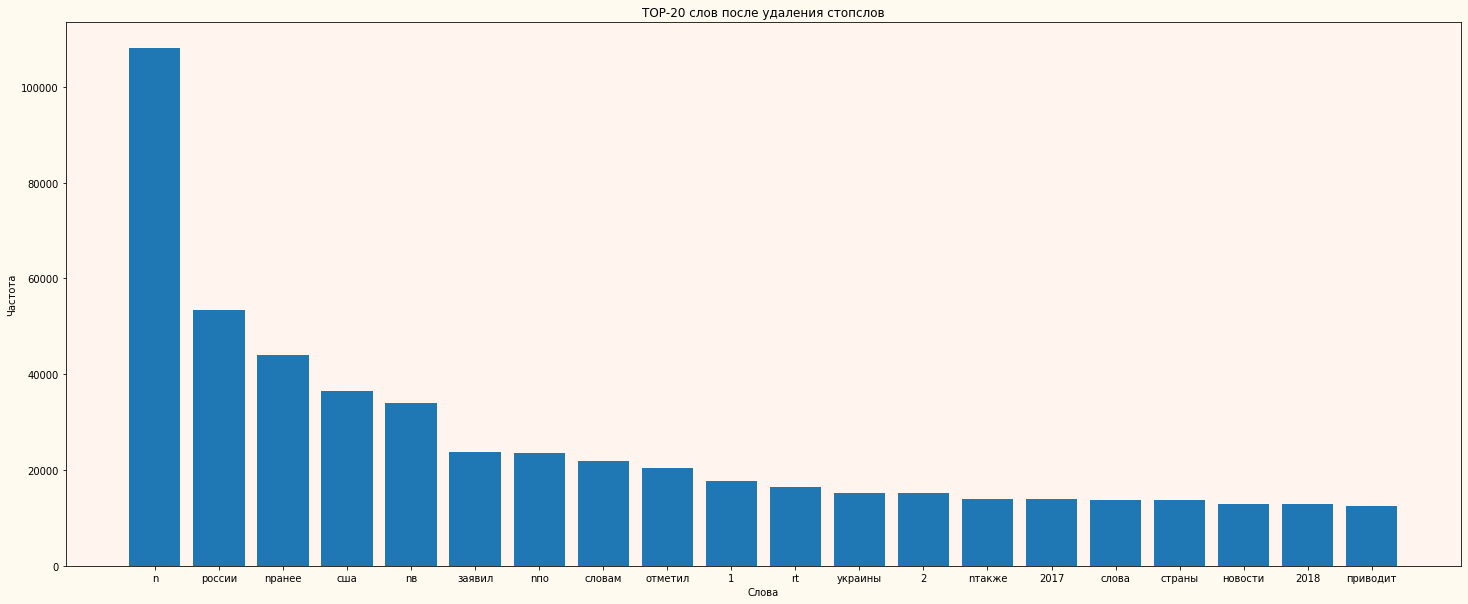

In [250]:
x = dict(dictionary_without_stopwords.most_common(20)).keys()
y = dict(dictionary_without_stopwords.most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов после удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(25)    #  ширина Figure
fig.set_figheight(10)    #  высота Figure


plt.show()

### Рубрики RT

In [251]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_rt.topics.unique().shape)
data_rt['topics'].unique()

Количество рубрик =  (10,)


array(['Россия', 'Спорт', 'Мир', 'Без политики', 'Новости партнёров',
       'Бывший СССР', 'Экономика', 'Наука', 'Мероприятия RT',
       'Пресс-релизы'], dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [252]:
data_rt.groupby('topics')['topics'].count().sort_values(ascending=False)

topics
Россия               32864
Спорт                26678
Мир                  26369
Бывший СССР          10074
Без политики          4437
Экономика             4316
Наука                 1493
Пресс-релизы            92
Новости партнёров       14
Мероприятия RT          13
Name: topics, dtype: int64